In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.model_selection import KFold, GroupKFold

In [2]:
from utils.utils import *
from tqdm.notebook import tqdm

Using TensorFlow backend.
/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sjnam/anaconda3/envs/infmtv_keras_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [3]:
%config InlineBackend.figure_format = 'retina'

In [4]:
K_FOLDS = 10

# Import results and calculate scores 

## baseline models 

In [5]:
base_result_dum = np.load("./model_predict_kapelner/baselines/base_result_0_dummy.npy", allow_pickle=True)
base_result_len = np.load("./model_predict_kapelner/baselines/base_result_1_len.npy", allow_pickle=True)
base_result_bow = np.load("./model_predict_kapelner/baselines/base_result_2_bow.npy", allow_pickle=True)

base_result_rfl = np.load("kapelner_rfreg_all_results.npy.npz", allow_pickle=True)['preds']

In [6]:
base_dum_rmse = [rmse(scr_true, scr_pred) for scr_true, scr_pred in zip(base_result_dum[0], base_result_dum[1])]
base_len_rmse = [rmse(scr_true, scr_pred) for scr_true, scr_pred in zip(base_result_len[0], base_result_len[1])]
base_bow_rmse = [rmse(scr_true, scr_pred) for scr_true, scr_pred in zip(base_result_bow[0], base_result_bow[1])]

base_rfl_rmse = [rmse(x['trues'], x['preds']) for x in base_result_rfl]

In [7]:
base_dum_rocauc_l2 = [1-rocauc(scr_true, scr_pred, 0.2, "low")  for scr_true, scr_pred in zip(base_result_dum[0], base_result_dum[1])]
base_dum_rocauc_m5 = [  rocauc(scr_true, scr_pred, 0.5, "high") for scr_true, scr_pred in zip(base_result_dum[0], base_result_dum[1])]
base_dum_rocauc_h8 = [  rocauc(scr_true, scr_pred, 0.8, "high") for scr_true, scr_pred in zip(base_result_dum[0], base_result_dum[1])]

base_len_rocauc_l2 = [1-rocauc(scr_true, scr_pred, 0.2, "low")  for scr_true, scr_pred in zip(base_result_len[0], base_result_len[1])]
base_len_rocauc_m5 = [  rocauc(scr_true, scr_pred, 0.5, "high") for scr_true, scr_pred in zip(base_result_len[0], base_result_len[1])]
base_len_rocauc_h8 = [  rocauc(scr_true, scr_pred, 0.8, "high") for scr_true, scr_pred in zip(base_result_len[0], base_result_len[1])]

base_bow_rocauc_l2 = [1-rocauc(scr_true, scr_pred, 0.2, "low")  for scr_true, scr_pred in zip(base_result_bow[0], base_result_bow[1])]
base_bow_rocauc_m5 = [  rocauc(scr_true, scr_pred, 0.5, "high") for scr_true, scr_pred in zip(base_result_bow[0], base_result_bow[1])]
base_bow_rocauc_h8 = [  rocauc(scr_true, scr_pred, 0.8, "high") for scr_true, scr_pred in zip(base_result_bow[0], base_result_bow[1])]

base_rfl_rocauc_l2 = [1-rocauc(x['trues'], x['preds'], 0.2, "low")  for x in base_result_rfl]
base_rfl_rocauc_m5 = [  rocauc(x['trues'], x['preds'], 0.5, "high") for x in base_result_rfl]
base_rfl_rocauc_h8 = [  rocauc(x['trues'], x['preds'], 0.8, "high") for x in base_result_rfl]

## ELMo-based models 

In [8]:
sent_notarg_elmo = np.load("kapelner_sentences_notarg_elmo_nocut.npy.npz", allow_pickle=True)

sentences_notarg_elmo=sent_notarg_elmo['sentences_notarg']
sentences_score_elmo=sent_notarg_elmo['sentences_score']
targets_elmo=sent_notarg_elmo['targets']

In [9]:
gkf = GroupKFold(n_splits=K_FOLDS)
gkf_split = gkf.split(sentences_notarg_elmo[0], groups=targets_elmo)
sentences_score_elmo_test = []

for train_idx, test_idx in tqdm(gkf_split):
    sentences_score_elmo_test.append(np.array(sentences_score_elmo)[test_idx])

In [10]:
elmo_nocut_atlx_pred = [np.load("./model_predict_kapelner/elmo/1emb/preds_elmo_notarg_wtattn_nocut_cv_lex_"+str(fold_idx)+".npy") for fold_idx in range(K_FOLDS)]
elmo_nocut_attn_pred = [np.load("./model_predict_kapelner/elmo/1emb/preds_elmo_notarg_wtattn_nocut_cv"+str(fold_idx)+".npy") for fold_idx in range(K_FOLDS)]
elmo_nocut_none_pred = [np.load("./model_predict_kapelner/elmo/1emb/preds_elmo_notarg_noattn_nocut_cv"+str(fold_idx)+".npy") for fold_idx in range(10)]

In [11]:
elmo_scr_rmse_atlx = [rmse(scr_true, scr_pred) for scr_true, scr_pred in zip(sentences_score_elmo_test, elmo_nocut_atlx_pred)]
elmo_scr_rmse_attn = [rmse(scr_true, scr_pred) for scr_true, scr_pred in zip(sentences_score_elmo_test, elmo_nocut_attn_pred)]
elmo_scr_rmse_none = [rmse(scr_true, scr_pred) for scr_true, scr_pred in zip(sentences_score_elmo_test, elmo_nocut_none_pred)]

In [12]:
elmo_scr_rocauc_atlx_l2 = [1-rocauc(scr_true, scr_pred, 0.2, "low")  for scr_true, scr_pred in zip(sentences_score_elmo_test, elmo_nocut_atlx_pred)]
elmo_scr_rocauc_atlx_m5 = [  rocauc(scr_true, scr_pred, 0.5, "high") for scr_true, scr_pred in zip(sentences_score_elmo_test, elmo_nocut_atlx_pred)]
elmo_scr_rocauc_atlx_h8 = [  rocauc(scr_true, scr_pred, 0.8, "high") for scr_true, scr_pred in zip(sentences_score_elmo_test, elmo_nocut_atlx_pred)]

elmo_scr_rocauc_attn_l2 = [1-rocauc(scr_true, scr_pred, 0.2, "low")  for scr_true, scr_pred in zip(sentences_score_elmo_test, elmo_nocut_attn_pred)]
elmo_scr_rocauc_attn_m5 = [  rocauc(scr_true, scr_pred, 0.5, "high") for scr_true, scr_pred in zip(sentences_score_elmo_test, elmo_nocut_attn_pred)]
elmo_scr_rocauc_attn_h8 = [  rocauc(scr_true, scr_pred, 0.8, "high") for scr_true, scr_pred in zip(sentences_score_elmo_test, elmo_nocut_attn_pred)]

elmo_scr_rocauc_none_l2 = [1-rocauc(scr_true, scr_pred, 0.2, "low")  for scr_true, scr_pred in zip(sentences_score_elmo_test, elmo_nocut_none_pred)]
elmo_scr_rocauc_none_m5 = [  rocauc(scr_true, scr_pred, 0.5, "high") for scr_true, scr_pred in zip(sentences_score_elmo_test, elmo_nocut_none_pred)]
elmo_scr_rocauc_none_h8 = [  rocauc(scr_true, scr_pred, 0.8, "high") for scr_true, scr_pred in zip(sentences_score_elmo_test, elmo_nocut_none_pred)]

## BERT-based models 

In [13]:
sent_notarg_bert = np.load("kapelner_sentences_notarg_bert_nocut.npy.npz", allow_pickle=True)

input_ids_bert = sent_notarg_bert['input_ids']
targets_bert = sent_notarg_bert['targets']
scores_bert = sent_notarg_bert['scores']

In [14]:
gkf = GroupKFold(n_splits=K_FOLDS)
gkf_split = gkf.split(input_ids_bert, groups=targets_bert)

sentences_score_bert_test = []
for train_idx, test_idx in tqdm(gkf_split):
    sentences_score_bert_test.append(np.reshape(scores_bert[test_idx], -1))

In [15]:
bert_nocut_atlx_pred = [np.load("./model_predict_kapelner/bert/1emb/preds_bert_notarg_wtattn_nocut_cv_lex_"+str(fold_idx)+".npy") for fold_idx in range(K_FOLDS)]
bert_nocut_attn_pred = [np.load("./model_predict_kapelner/bert/1emb/preds_bert_notarg_wtattn_nocut_cv_"+str(fold_idx)+".npy") for fold_idx in range(K_FOLDS)]
bert_nocut_none_pred = [np.load("./model_predict_kapelner/bert/1emb/preds_bert_notarg_noattn_nocut_cv_"+str(fold_idx)+".npy") for fold_idx in range(10)]

In [16]:
bert_scr_rmse_atlx = [rmse(scr_true, scr_pred) for scr_true, scr_pred in zip(sentences_score_bert_test, bert_nocut_atlx_pred)]
bert_scr_rmse_attn = [rmse(scr_true, scr_pred) for scr_true, scr_pred in zip(sentences_score_bert_test, bert_nocut_attn_pred)]
bert_scr_rmse_none = [rmse(scr_true, scr_pred) for scr_true, scr_pred in zip(sentences_score_bert_test, bert_nocut_none_pred)]

In [17]:
bert_scr_rocauc_atlx_l2 = [1-rocauc(scr_true, scr_pred, 0.2, "low")  for scr_true, scr_pred in zip(sentences_score_elmo_test, bert_nocut_atlx_pred)]
bert_scr_rocauc_atlx_m5 = [  rocauc(scr_true, scr_pred, 0.5, "high") for scr_true, scr_pred in zip(sentences_score_elmo_test, bert_nocut_atlx_pred)]
bert_scr_rocauc_atlx_h8 = [  rocauc(scr_true, scr_pred, 0.8, "high") for scr_true, scr_pred in zip(sentences_score_elmo_test, bert_nocut_atlx_pred)]

bert_scr_rocauc_attn_l2 = [1-rocauc(scr_true, scr_pred, 0.2, "low")  for scr_true, scr_pred in zip(sentences_score_elmo_test, bert_nocut_attn_pred)]
bert_scr_rocauc_attn_m5 = [  rocauc(scr_true, scr_pred, 0.5, "high") for scr_true, scr_pred in zip(sentences_score_elmo_test, bert_nocut_attn_pred)]
bert_scr_rocauc_attn_h8 = [  rocauc(scr_true, scr_pred, 0.8, "high") for scr_true, scr_pred in zip(sentences_score_elmo_test, bert_nocut_attn_pred)]

bert_scr_rocauc_none_l2 = [1-rocauc(scr_true, scr_pred, 0.2, "low")  for scr_true, scr_pred in zip(sentences_score_elmo_test, bert_nocut_none_pred)]
bert_scr_rocauc_none_m5 = [  rocauc(scr_true, scr_pred, 0.5, "high") for scr_true, scr_pred in zip(sentences_score_elmo_test, bert_nocut_none_pred)]
bert_scr_rocauc_none_h8 = [  rocauc(scr_true, scr_pred, 0.8, "high") for scr_true, scr_pred in zip(sentences_score_elmo_test, bert_nocut_none_pred)]

# Consolidate scores 

In [18]:
scr_rmse = pd.DataFrame({"Baseline\n-Avg":     base_dum_rmse,
                         "Baseline\n-SentLen": base_len_rmse,
                         "Baseline\n-BoW":     base_bow_rmse,
                         "Kapelner et al.\n":     base_rfl_rmse,
                         "ELMo\n+Att+Lex":elmo_scr_rmse_atlx,
                         "ELMo\n+Att    ":elmo_scr_rmse_attn,
                         "ELMo\n        ":elmo_scr_rmse_none, 
                         "BERT\n+Att+Lex":bert_scr_rmse_atlx,
                         "BERT\n+Att    ":bert_scr_rmse_attn,
                         "BERT\n        ":bert_scr_rmse_none,})

In [19]:
scr_rmse

,Baseline -Avg,Baseline -SentLen,Baseline -BoW,Kapelner et al.,ELMo +Att+Lex,ELMo +Att,ELMo,BERT +Att+Lex,BERT +Att,BERT
0,0.168925,0.168861,0.206051,0.152322,0.171142,0.153081,0.153746,0.139989,0.140205,0.144138
1,0.172667,0.172655,0.210691,0.155281,0.143135,0.148150,0.150895,0.136335,0.136971,0.139629
2,0.172932,0.172866,0.212031,0.157769,0.163976,0.153062,0.149513,0.133556,0.134876,0.143348
3,0.176234,0.176282,0.208238,0.158848,0.146104,0.146771,0.147620,0.135201,0.136362,0.139069
4,0.175182,0.175166,0.207648,0.157559,0.142935,0.145264,0.145515,0.135048,0.136083,0.146306
5,0.169334,0.169287,0.202874,0.152693,0.148440,0.155233,0.153424,0.140483,0.141245,0.150745
6,0.171678,0.171639,0.209878,0.154921,0.150850,0.150756,0.150168,0.147337,0.139277,0.144355
7,0.179154,0.179084,0.207884,0.161370,0.148867,0.161095,0.156474,0.138005,0.137655,0.148188
8,0.179592,0.179606,0.211775,0.162056,0.154172,0.152931,0.156698,0.141242,0.137893,0.143909
9,0.168240,0.168194,0.209195,0.154864,0.153179,0.160467,0.158163,0.140817,0.144039,0.154472


In [20]:
scr_rmse.apply(lambda col:ci(col, digits=3), axis=0)

Baseline\n-Avg         (0.173, 0.17, 0.176)
Baseline\n-SentLen     (0.173, 0.17, 0.176)
Baseline\n-BoW        (0.209, 0.207, 0.211)
Kapelner et al.\n     (0.157, 0.154, 0.159)
ELMo\n+Att+Lex        (0.152, 0.146, 0.159)
ELMo\n+Att            (0.153, 0.149, 0.156)
ELMo\n                (0.152, 0.149, 0.155)
BERT\n+Att+Lex        (0.139, 0.136, 0.142)
BERT\n+Att             (0.138, 0.136, 0.14)
BERT\n                (0.145, 0.142, 0.149)
dtype: object

In [21]:
scr_rocauc = pd.DataFrame({"Baseline\n-Avg_l2":base_dum_rocauc_l2,
                           "Baseline\n-Avg_m5":base_dum_rocauc_m5,
                           "Baseline\n-Avg_h8":base_dum_rocauc_h8,
                           "Baseline\n-SentLen_l2":base_len_rocauc_l2,
                           "Baseline\n-SentLen_m5":base_len_rocauc_m5,
                           "Baseline\n-SentLen_h8":base_len_rocauc_h8,
                           "Baseline\n-BoW_l2":base_bow_rocauc_l2,
                           "Baseline\n-BoW_m5":base_bow_rocauc_m5,
                           "Baseline\n-BoW_h8":base_bow_rocauc_h8,
                           "Kapelner et al.\n_l2":base_rfl_rocauc_l2,
                           "Kapelner et al.\n_m5":base_rfl_rocauc_m5,
                           "Kapelner et al.\n_h8":base_rfl_rocauc_h8,
                           "ELMo\n        _l2":elmo_scr_rocauc_none_l2, 
                           "ELMo\n        _m5":elmo_scr_rocauc_none_m5, 
                           "ELMo\n        _h8":elmo_scr_rocauc_none_h8, 
                           "ELMo\n+Att    _l2":elmo_scr_rocauc_attn_l2,
                           "ELMo\n+Att    _m5":elmo_scr_rocauc_attn_m5,
                           "ELMo\n+Att    _h8":elmo_scr_rocauc_attn_h8,
                           "ELMo\n+Att+Lex_l2":elmo_scr_rocauc_atlx_l2,
                           "ELMo\n+Att+Lex_m5":elmo_scr_rocauc_atlx_m5,
                           "ELMo\n+Att+Lex_h8":elmo_scr_rocauc_atlx_h8,
                           "BERT\n        _l2":bert_scr_rocauc_none_l2,
                           "BERT\n        _m5":bert_scr_rocauc_none_m5,
                           "BERT\n        _h8":bert_scr_rocauc_none_h8,
                           "BERT\n+Att    _l2":bert_scr_rocauc_attn_l2, 
                           "BERT\n+Att    _m5":bert_scr_rocauc_attn_m5, 
                           "BERT\n+Att    _h8":bert_scr_rocauc_attn_h8, 
                           "BERT\n+Att+Lex_l2":bert_scr_rocauc_atlx_l2,
                           "BERT\n+Att+Lex_m5":bert_scr_rocauc_atlx_m5,
                           "BERT\n+Att+Lex_h8":bert_scr_rocauc_atlx_h8,})

In [22]:
scr_rocauc

,Baseline -Avg_l2,Baseline -Avg_m5,Baseline -Avg_h8,Baseline -SentLen_l2,Baseline -SentLen_m5,Baseline -SentLen_h8,Baseline -BoW_l2,Baseline -BoW_m5,Baseline -BoW_h8,Kapelner et al. _l2,...,ELMo +Att+Lex_h8,BERT _l2,BERT _m5,BERT _h8,BERT +Att _l2,BERT +Att _m5,BERT +Att _h8,BERT +Att+Lex_l2,BERT +Att+Lex_m5,BERT +Att+Lex_h8
0,0.5,0.5,0.5,0.511116,0.518823,0.512632,0.623025,0.591219,0.572700,0.740203,...,0.730855,0.809527,0.767687,0.762168,0.822403,0.781544,0.775168,0.825447,0.777106,0.773933
1,0.5,0.5,0.5,0.496407,0.504064,0.499629,0.610830,0.580222,0.577230,0.735011,...,0.728088,0.815088,0.758357,0.744284,0.816519,0.768915,0.753595,0.825200,0.773613,0.764202
2,0.5,0.5,0.5,0.510169,0.515324,0.511683,0.625280,0.576377,0.572960,0.722552,...,0.724521,0.800217,0.761380,0.764316,0.816256,0.773728,0.789025,0.823836,0.781240,0.792920
3,0.5,0.5,0.5,0.505769,0.492721,0.492037,0.636559,0.595337,0.587090,0.743578,...,0.722298,0.795344,0.759699,0.745236,0.803013,0.773797,0.763035,0.818290,0.778445,0.770223
4,0.5,0.5,0.5,0.506044,0.512173,0.496665,0.641653,0.593225,0.578057,0.746333,...,0.716001,0.777616,0.750317,0.728959,0.786432,0.762225,0.750969,0.798149,0.766501,0.759549
5,0.5,0.5,0.5,0.518120,0.499848,0.507863,0.642348,0.594894,0.579774,0.731798,...,0.712892,0.810753,0.755109,0.729123,0.824839,0.778346,0.748319,0.828343,0.785476,0.761322
6,0.5,0.5,0.5,0.525729,0.510719,0.489141,0.611880,0.578929,0.565198,0.730494,...,0.740682,0.811389,0.782870,0.781283,0.825449,0.795484,0.792897,0.828741,0.797523,0.789360
7,0.5,0.5,0.5,0.522087,0.515325,0.510138,0.646936,0.600637,0.593663,0.744384,...,0.731443,0.810325,0.779173,0.762820,0.818880,0.792981,0.773176,0.814481,0.789010,0.777955
8,0.5,0.5,0.5,0.509425,0.490779,0.489443,0.642591,0.599742,0.592129,0.745504,...,0.714165,0.810163,0.758588,0.741253,0.811074,0.766996,0.761049,0.816623,0.775962,0.767350
9,0.5,0.5,0.5,0.506857,0.507821,0.513401,0.614895,0.579542,0.567046,0.719689,...,0.730295,0.830731,0.770807,0.753694,0.833725,0.778498,0.768103,0.845425,0.790306,0.774929


In [23]:
scr_rocauc.apply(lambda col:ci(col, digits=3), axis=0)

Baseline\n-Avg_l2              (0.5, 0.5, 0.5)
Baseline\n-Avg_m5              (0.5, 0.5, 0.5)
Baseline\n-Avg_h8              (0.5, 0.5, 0.5)
Baseline\n-SentLen_l2    (0.511, 0.505, 0.517)
Baseline\n-SentLen_m5      (0.507, 0.5, 0.514)
Baseline\n-SentLen_h8    (0.502, 0.495, 0.509)
Baseline\n-BoW_l2           (0.63, 0.62, 0.64)
Baseline\n-BoW_m5        (0.589, 0.582, 0.596)
Baseline\n-BoW_h8        (0.579, 0.572, 0.586)
Kapelner et al.\n_l2     (0.736, 0.729, 0.743)
Kapelner et al.\n_m5     (0.698, 0.691, 0.705)
Kapelner et al.\n_h8      (0.68, 0.669, 0.692)
ELMo\n        _l2        (0.768, 0.757, 0.779)
ELMo\n        _m5        (0.729, 0.721, 0.737)
ELMo\n        _h8        (0.705, 0.696, 0.715)
ELMo\n+Att    _l2           (0.77, 0.76, 0.78)
ELMo\n+Att    _m5         (0.727, 0.72, 0.734)
ELMo\n+Att    _h8        (0.701, 0.689, 0.713)
ELMo\n+Att+Lex_l2        (0.789, 0.779, 0.799)
ELMo\n+Att+Lex_m5        (0.746, 0.739, 0.754)
ELMo\n+Att+Lex_h8        (0.725, 0.719, 0.731)
BERT\n       

# Plotting

In [24]:
tt_rmse = scr_rmse[['Baseline\n-Avg', 'Baseline\n-BoW', 'Baseline\n-SentLen', "Kapelner et al.\n",
                    "ELMo\n        ", "ELMo\n+Att    ", "ELMo\n+Att+Lex", 
                    "BERT\n        ", "BERT\n+Att    ", "BERT\n+Att+Lex", ]]
tt_rmse.columns = [x+"_1-rmse" for x in list(tt_rmse.columns)]
tt_rmse = pd.melt(tt_rmse)
tt_rmse['value'] = 1-tt_rmse['value']

In [25]:
tt_rmse.head(50)

,variable,value
0,Baseline\n-Avg_1-rmse,0.831075
1,Baseline\n-Avg_1-rmse,0.827333
2,Baseline\n-Avg_1-rmse,0.827068
3,Baseline\n-Avg_1-rmse,0.823766
4,Baseline\n-Avg_1-rmse,0.824818
5,Baseline\n-Avg_1-rmse,0.830666
6,Baseline\n-Avg_1-rmse,0.828322
7,Baseline\n-Avg_1-rmse,0.820846
8,Baseline\n-Avg_1-rmse,0.820408
9,Baseline\n-Avg_1-rmse,0.831760


In [26]:
tt_l2 = pd.melt(scr_rocauc[['Baseline\n-Avg_l2', 'Baseline\n-BoW_l2', 'Baseline\n-SentLen_l2', 'Kapelner et al.\n_l2',
                            'ELMo\n        _l2', 'ELMo\n+Att    _l2', 'ELMo\n+Att+Lex_l2',
                            'BERT\n        _l2', 'BERT\n+Att    _l2', 'BERT\n+Att+Lex_l2',]])
tt_m5 = pd.melt(scr_rocauc[['Baseline\n-Avg_m5', 'Baseline\n-BoW_m5', 'Baseline\n-SentLen_m5', 'Kapelner et al.\n_m5',
                            'ELMo\n        _m5', 'ELMo\n+Att    _m5', 'ELMo\n+Att+Lex_m5',
                            'BERT\n        _m5', 'BERT\n+Att    _m5', 'BERT\n+Att+Lex_m5',]])
tt_h8 = pd.melt(scr_rocauc[['Baseline\n-Avg_h8', 'Baseline\n-BoW_h8', 'Baseline\n-SentLen_h8', 'Kapelner et al.\n_h8',
                            'ELMo\n        _h8', 'ELMo\n+Att    _h8', 'ELMo\n+Att+Lex_h8',
                            'BERT\n        _h8', 'BERT\n+Att    _h8', 'BERT\n+Att+Lex_h8',]])

tt = pd.concat([tt_rmse, tt_l2, tt_m5, tt_h8], axis=0)
# tt = tt_l2

In [27]:
tt['category'] = tt['variable'].apply(lambda x:x.split('\n')[0])
tt['models'] = tt['variable'].apply(lambda x:x.split('\n')[0] + x.split('\n')[-1].split('_')[0])
tt['score_type'] = tt['variable'].apply(lambda x:x.split('\n')[-1].split('_')[1])

In [28]:
tt.head(50)

,variable,value,category,models,score_type
0,Baseline\n-Avg_1-rmse,0.831075,Baseline,Baseline-Avg,1-rmse
1,Baseline\n-Avg_1-rmse,0.827333,Baseline,Baseline-Avg,1-rmse
2,Baseline\n-Avg_1-rmse,0.827068,Baseline,Baseline-Avg,1-rmse
3,Baseline\n-Avg_1-rmse,0.823766,Baseline,Baseline-Avg,1-rmse
4,Baseline\n-Avg_1-rmse,0.824818,Baseline,Baseline-Avg,1-rmse
5,Baseline\n-Avg_1-rmse,0.830666,Baseline,Baseline-Avg,1-rmse
6,Baseline\n-Avg_1-rmse,0.828322,Baseline,Baseline-Avg,1-rmse
7,Baseline\n-Avg_1-rmse,0.820846,Baseline,Baseline-Avg,1-rmse
8,Baseline\n-Avg_1-rmse,0.820408,Baseline,Baseline-Avg,1-rmse
9,Baseline\n-Avg_1-rmse,0.831760,Baseline,Baseline-Avg,1-rmse


In [29]:
import itertools

Text(0.5,0,'Score Type')

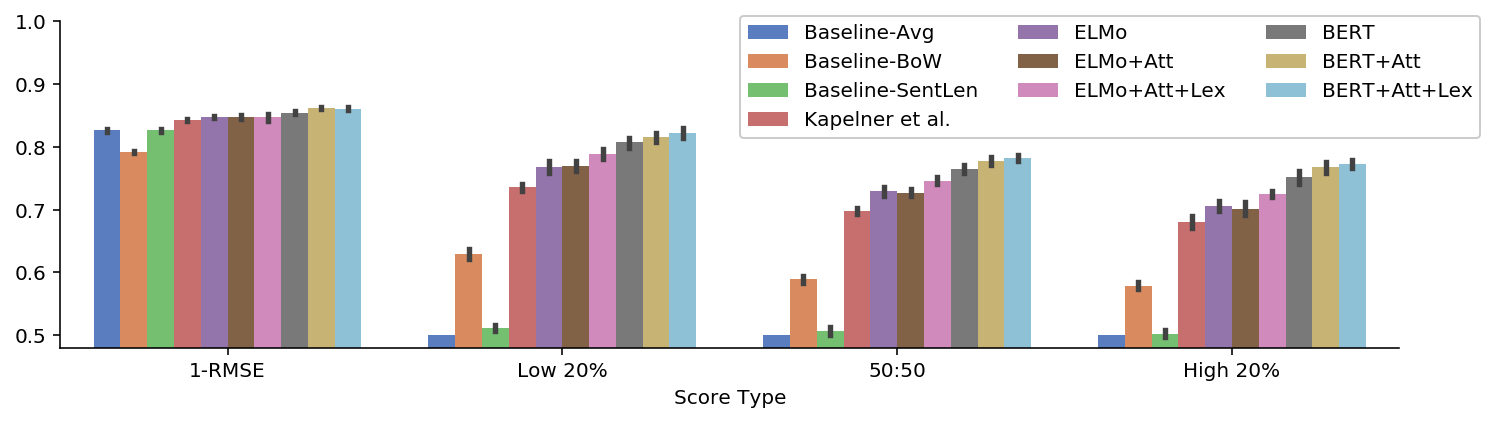

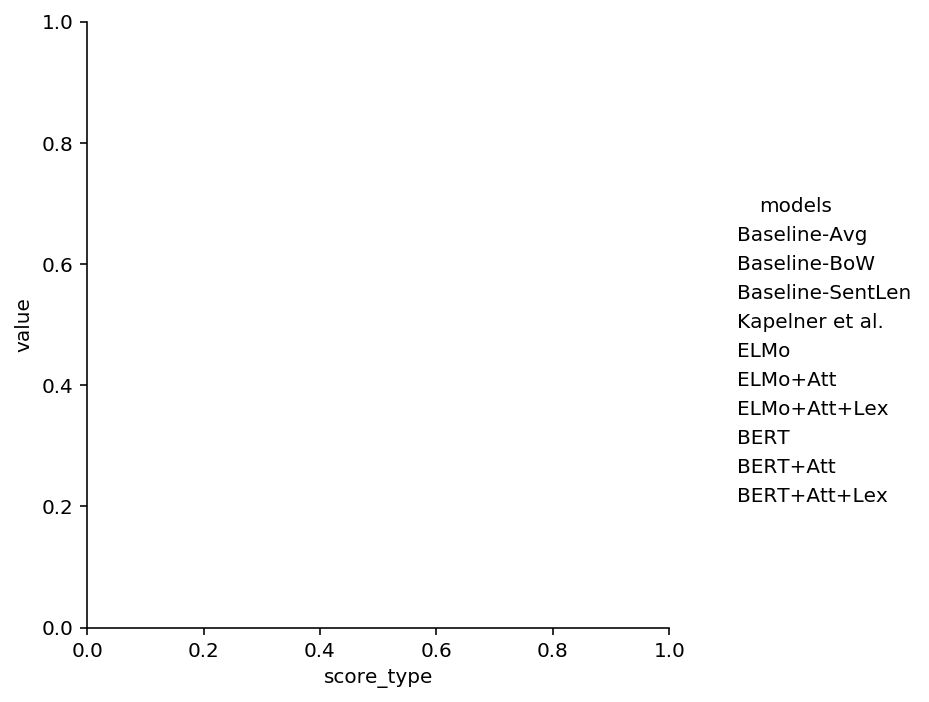

In [30]:
# TODO: add spaces per model type

%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots(1, 1, figsize=(12, 3))
sns.catplot(x='score_type', y='value', hue='models',
#             hueorder=['Baseline-Avg', 'Baseline-BoW', 'Baseline-SentLen', 'Baseline-Rf', 
#                      'ELMo_']
            kind="bar", palette="muted",
            data=tt, 
            ax=ax)

# # hatches = itertools.cycle(['-', '-', '-', '-', '//', '//', '//', '+', '+', '+'])
# hatches = ['-', '-', '-', '-', '//', '//', '//', '+', '+', '+',
#            '-', '-', '-', '-', '//', '//', '//', '+', '+', '+',
#            '-', '-', '-', '-', '//', '//', '//', '+', '+', '+']
# for i, bar in enumerate(ax.patches):
#     bar.set_hatch(hatches[i])
# #     if((i > 0) & ((i%4)==0)):
# #         p.set_x(p.get_x()+0.1)

ax.set_ylim(0.48, 1)
ax.set_xticklabels(['1-RMSE', 'Low 20%', '50:50', 'High 20%'])
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=handles, loc='center left', bbox_to_anchor=(0.5, 0.83), 
          ncol=3,
          facecolor='white', framealpha=1.0,)
#           labels=['Base: Avg.', 'Base: BoW', 'Base: SentLen',
#                   'ELMo+Att+Lex', 'ELMo + Att', 'ELMo',
#                   'BERT+Att+Lex', 'BERT + Att', 'BERT'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("")
ax.set_xlabel("Score Type")

# fig.savefig("result2_4_summary.png", dpi=300)

[Text(0,0,'Bottom 20% Infomative'),
 Text(0,0,'50:50'),
 Text(0,0,'Top 20% Infomative')]

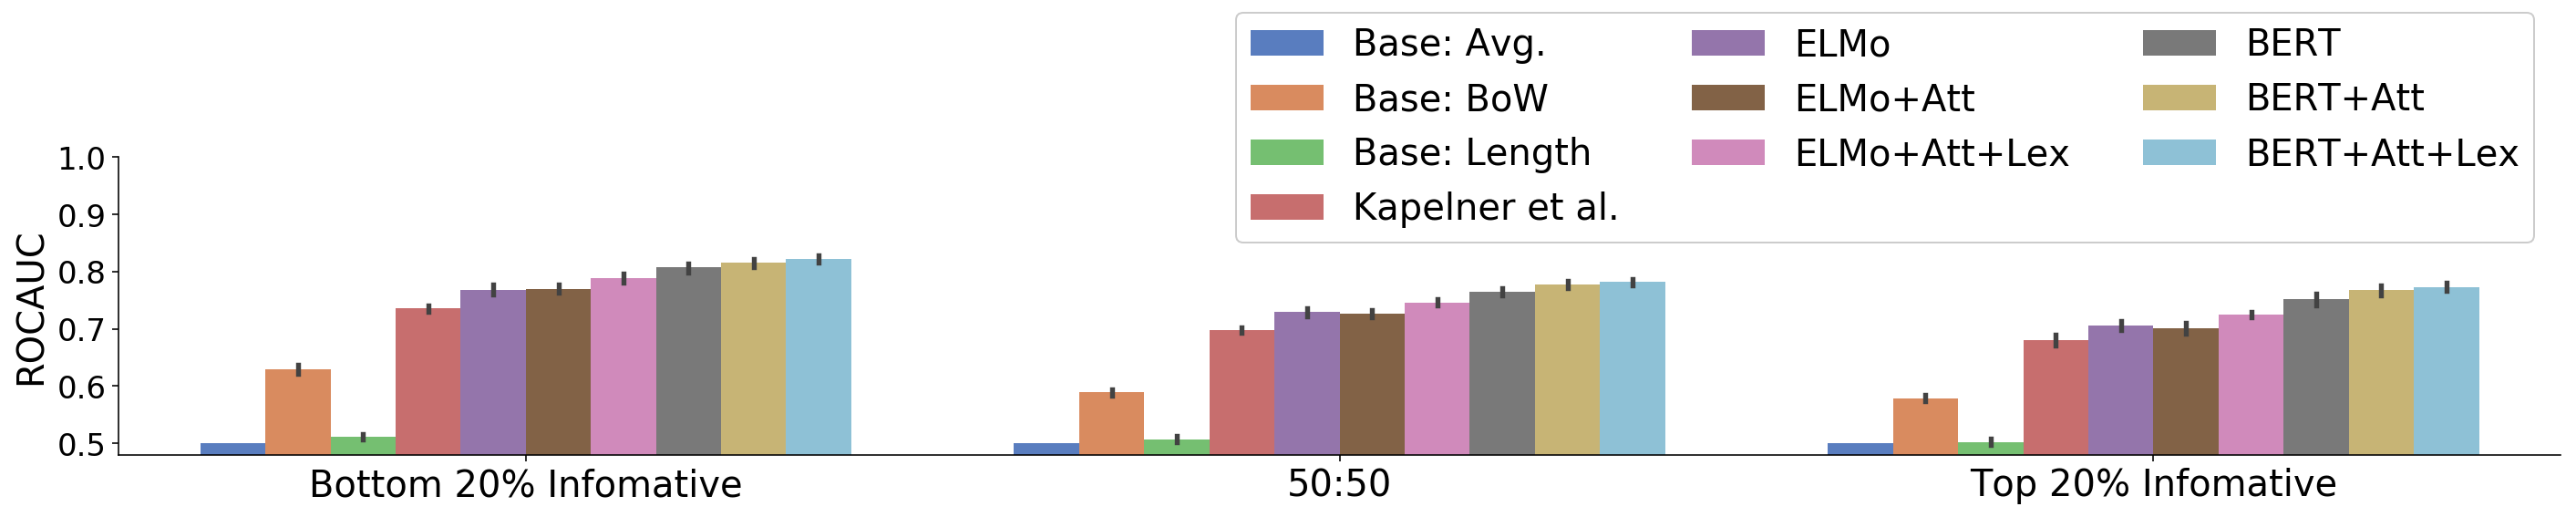

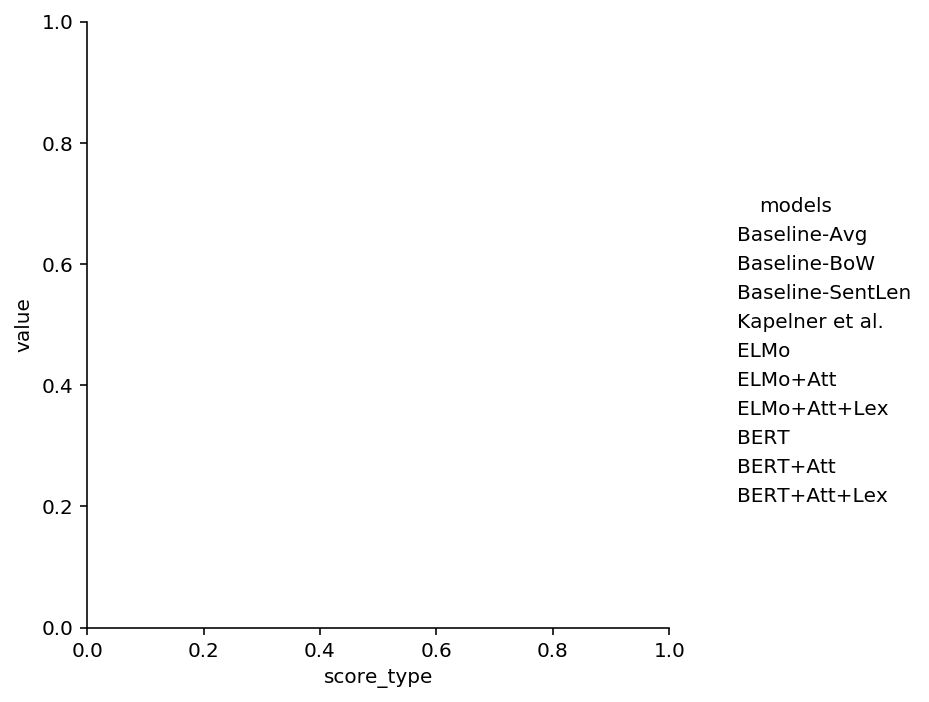

In [39]:
# TODO: add spaces per model type

%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots(1, 1, figsize=(24, 3))
sns.catplot(x='score_type', y='value', hue='models',
#             hueorder=['Baseline-Avg', 'Baseline-BoW', 'Baseline-SentLen', 'Baseline-Rf', 
#                      'ELMo_']
            kind="bar", palette="muted",
            data=tt[tt['score_type']!='1-rmse'], 
            ax=ax)

# # hatches = itertools.cycle(['-', '-', '-', '-', '//', '//', '//', '+', '+', '+'])
# hatches = ['-', '-', '-', '-', '//', '//', '//', '+', '+', '+',
#            '-', '-', '-', '-', '//', '//', '//', '+', '+', '+',
#            '-', '-', '-', '-', '//', '//', '//', '+', '+', '+']
# for i, bar in enumerate(ax.patches):
#     bar.set_hatch(hatches[i])
# #     if((i > 0) & ((i%4)==0)):
# #         p.set_x(p.get_x()+0.1)

ax.set_ylim(0.48, 1)

handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=handles, loc='center left', bbox_to_anchor=(0.45, 1.1),
            ncol=3, fontsize=20,
            facecolor='white', framealpha=1.0,
            labels=['Base: Avg.', 'Base: BoW', 'Base: Length', 'Kapelner et al.',
                    'ELMo', 'ELMo+Att', 'ELMo+Att+Lex',
                    'BERT', 'BERT+Att', 'BERT+Att+Lex',])
# L.get_texts()[3].set_text('Kapelner et al. (RF-Lex)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

[ytick.label.set_fontsize(17) for ytick in ax.yaxis.get_major_ticks()]
ax.set_ylabel("ROCAUC", fontsize=20)

ax.set_xlabel("")
ax.set_xticklabels(['Bottom 20% Infomative', '50:50', 'Top 20% Infomative'], fontsize=20)

# fig.savefig("result2_4_summary_wider.pdf", dpi=300, bbox_inches = 'tight')